In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim

In [2]:
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [3]:
from DeepGenerativeModels.AutoEncoders import VAE
from DeepGenerativeModels.AutoEncoders import IWAE

In [4]:
import utils

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

# Обучение

## VAE

In [7]:
model = VAE(2, 28*28, device=device)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
utils.trainer(model = model, 
        optimizer = optimizer, 
        dataset = train_data, 
        count_of_epoch = 10,
        batch_size = 64,
        callback = None,
        progress = tqdm)

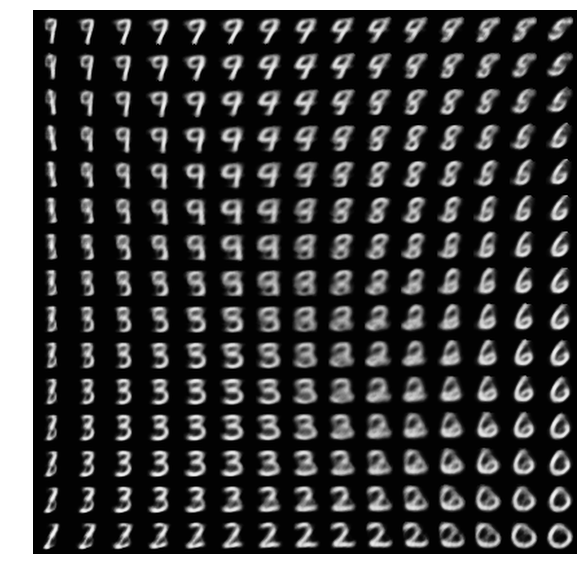

In [10]:
figure = utils.draw_samples_grid_vae(model)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

## IWAE

In [11]:
model = IWAE(2, 28*28, K = 10, device=device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
utils.trainer(model = model, 
        optimizer = optimizer, 
        dataset = train_data, 
        count_of_epoch = 10,
        batch_size = 64,
        callback = None,
        progress = tqdm)

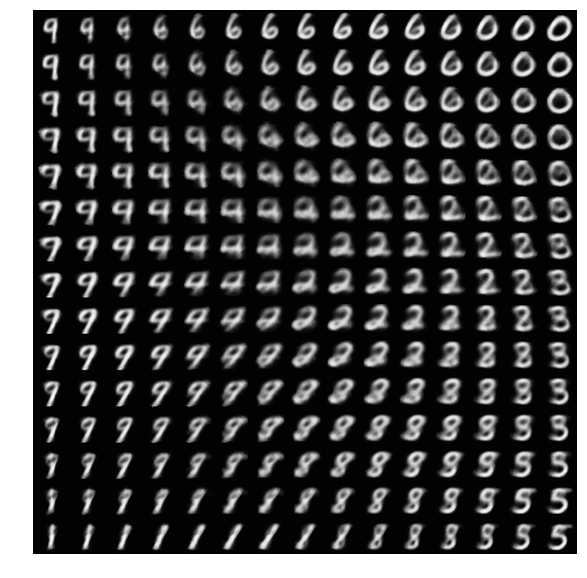

In [14]:
figure = utils.draw_samples_grid_vae(model)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()